In [15]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap
import tensorflow as tf
import json

In [16]:
POP_COLORING = [
    {'from': 0, 'to': 5, 'color': 'blue'},
    {'from': 5, 'to': 20, 'color': 'cyan'},
    {'from': 20, 'to': 50, 'color': 'green'},
    {'from': 50, 'to': 150, 'color': 'yellow'},
    {'from': 150, 'to': 300, 'color': 'orange'},
    {'from': 300, 'to': 500, 'color': 'red'},
    {'from': 500, 'to': None, 'color': 'darkred'}
]

def get_cmap(coloring):
  l = coloring[-1]
  cmap = LinearSegmentedColormap.from_list("custom_cmap", [(c['from'] / l['from'], c['color']) for c in coloring])
  return cmap

def plot_pop(ax, data, alpha=1, coloring=POP_COLORING):
  cmap = get_cmap(coloring)
  ax.imshow(data, cmap=cmap, alpha=alpha, vmin=POP_COLORING[0]['from'], vmax=POP_COLORING[-1]['from'])

In [17]:
def get_axes(x=1, y=1, scale=6):
    fig, axes = plt.subplots(y, x, figsize=(x * scale, y * scale))

    # Ensure `axes` is always a 2D numpy array
    if x == 1 and y == 1:
        axes = np.array([[axes]])
    elif x == 1:
        axes = np.array(axes).reshape(-1, 1)
    elif y == 1:
        axes = np.array(axes).reshape(1, -1)

    # Assign the scale as an attribute for each axis
    for ax in axes.flat:
        ax.scale = scale
        ax.axis('off')

    return axes

In [18]:
def plot_text(ax, text):
    text = ax.text(0.5, 0, text, transform=ax.transAxes, fontsize=ax.scale*4, ha='center', va='bottom', color='black', fontweight='bold')
    text.set_path_effects([path_effects.Stroke(linewidth=ax.scale, foreground="white"),path_effects.Normal()])

In [19]:
prefix = ""

osm = np.load(f'./downloads/{prefix}osm.npy')
viirs = s1 = np.load(f'./downloads/{prefix}viirs.npy')['avg_rad']
s1 = np.load(f'./downloads/{prefix}s1.npy')
s2_a = np.load(f'./downloads/{prefix}s2_a.npy')
s2_b = np.load(f'./downloads/{prefix}s2_b.npy')
census = np.load(f'./downloads/{prefix}census.npy')['den']; census[census == 0] = np.nan
census_100 = np.load(f'./downloads/{prefix}census_100.npy')['den']; census_100[census_100 == 0] = np.nan
census_250 = np.load(f'./downloads/{prefix}census_250.npy')['den']; census_250[census_250 == 0] = np.nan
census_500 = np.load(f'./downloads/{prefix}census_500.npy')['den']; census_500[census_500 == 0] = np.nan
census_1000 = np.load(f'./downloads/{prefix}census_1000.npy')['den']; census_1000[census_1000 == 0] = np.nan

In [20]:
def standardize(data, mean, std):
  return (data - mean) / std

def unstandardize(data, mean, std):
  return data * std + mean

with open('./statistics.json', 'r') as f:
  stats = json.load(f)

fetures = np.stack(
  [
    standardize(s2_a['B1'],    stats['b1_mean'], stats['b1_std']),
    standardize(s2_a['B2'],    stats['b2_mean'], stats['b2_std']),
    standardize(s2_a['B3'],    stats['b3_mean'], stats['b3_std']),
    standardize(s2_a['B4'],    stats['b4_mean'], stats['b4_std']),
    standardize(s2_a['B5'],    stats['b5_mean'], stats['b5_std']),
    standardize(s2_a['B6'],    stats['b6_mean'], stats['b6_std']),
    standardize(s2_b['B7'],    stats['b7_mean'], stats['b7_std']),
    standardize(s2_b['B8'],    stats['b8_mean'], stats['b8_std']),
    standardize(s2_b['B8A'],   stats['b8a_mean'], stats['b8a_std']),
    standardize(s2_b['B9'],    stats['b9_mean'], stats['b9_std']),
    standardize(s2_b['B11'],   stats['b11_mean'], stats['b11_std']),
    standardize(s2_b['B12'],   stats['b12_mean'], stats['b12_std']),
    standardize(viirs, stats['night_mean'], stats['night_std']),
    standardize(s1['VH'],    stats['vh_mean'], stats['vh_std']),
    standardize(s1['VV'],    stats['vv_mean'], stats['vv_std'])
  ],
  axis=-1
)

model = tf.keras.models.load_model(f'./m8f150m5x5_custom.mse.False.keras', compile=False)
preds = unstandardize(model.predict(np.array([fetures])), stats['pop_mean'], stats['pop_std'])[0,:,:,0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


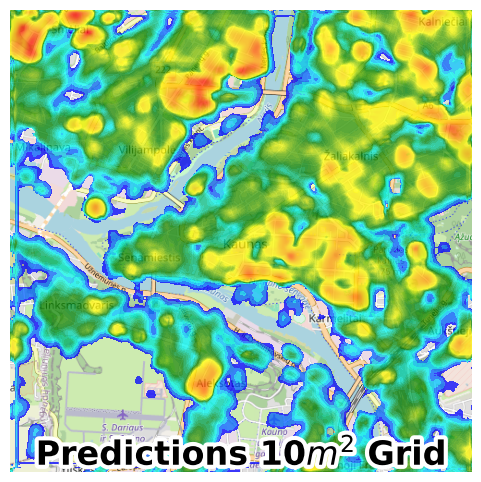

In [21]:
path = '../graphviz/images/'

preds[preds < 1] = np.nan

ax = get_axes()
ax[0,0].imshow(osm, alpha=1)
plot_pop(ax[0,0], preds, alpha=0.75)
plot_text(ax[0,0], "Predictions 10$m^2$ Grid")
plt.savefig(f"{path}predictions.png", bbox_inches='tight', pad_inches=0)
plt.show()

In [22]:
s1_rgb = np.stack([s2_a["B4"], s2_a["B3"], s2_a["B2"]], axis=-1)
s1_rgb = s1_rgb / 3000
s1_rgb[s1_rgb<0] = 0.0
s1_rgb[s1_rgb>1] = 1.0

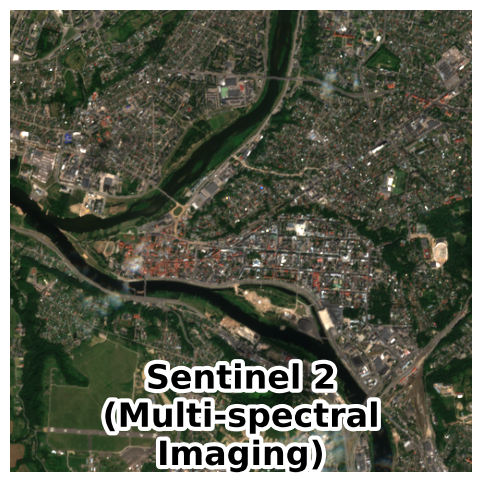

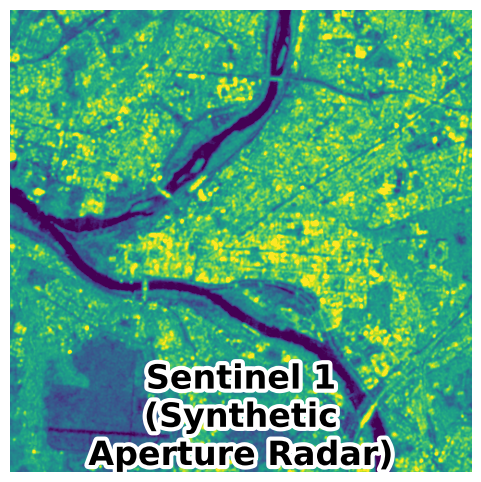

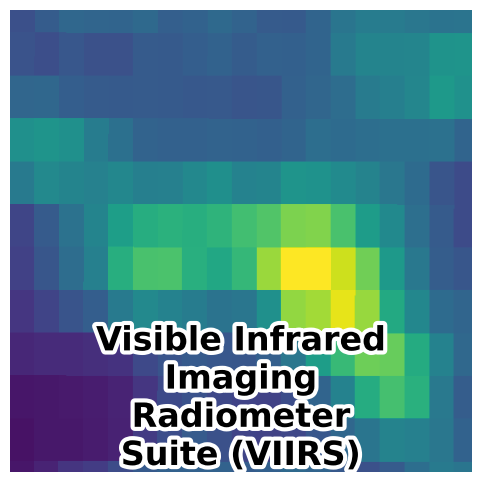

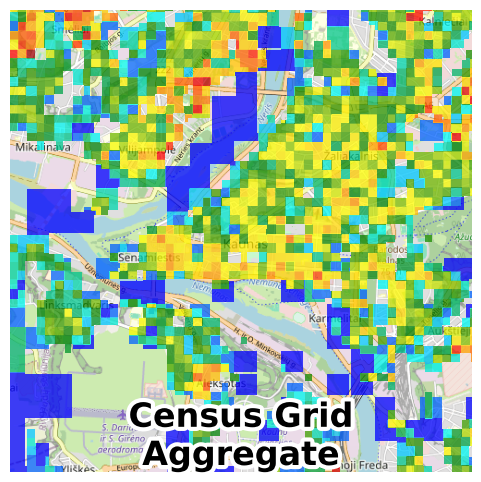

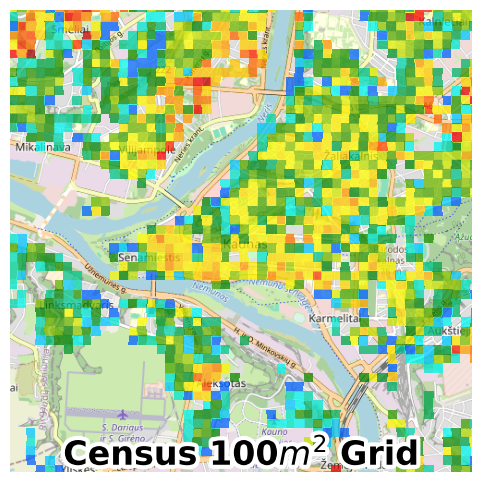

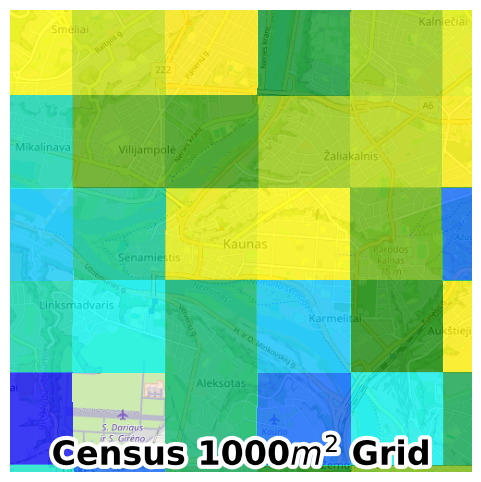

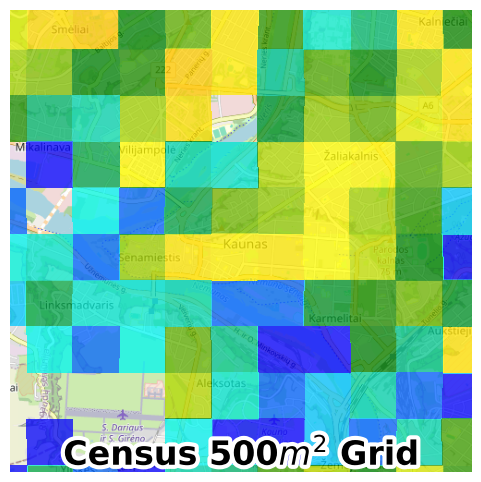

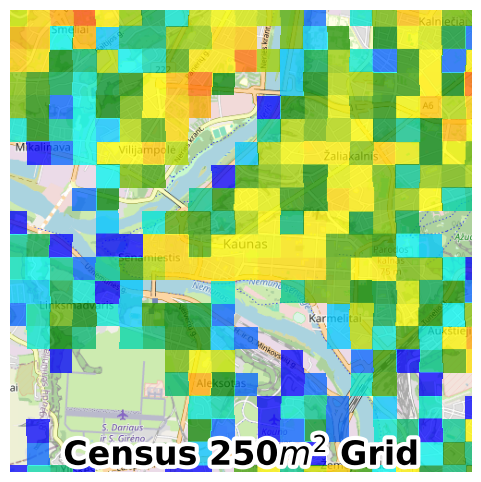

In [23]:
path = '../graphviz/images/'

ax = get_axes()
ax[0,0].imshow(s1_rgb, alpha=1, vmin=0, vmax=3000)
plot_text(ax[0,0], "Sentinel 2\n(Multi-spectral\nImaging)")
plt.savefig(f"{path}s2.png", bbox_inches='tight', pad_inches=0)
plt.show()

ax = get_axes()
ax[0,0].imshow(s1['VV'], alpha=1, vmin=-20, vmax=0)
plot_text(ax[0,0], "Sentinel 1\n(Synthetic\nAperture Radar)")
plt.savefig(f"{path}s1.png", bbox_inches='tight', pad_inches=0)
plt.show()

ax = get_axes()
ax[0,0].imshow(viirs, alpha=1, vmin=0, vmax=100)
plot_text(ax[0,0], "Visible Infrared\nImaging\nRadiometer\nSuite (VIIRS)")
plt.savefig(f"{path}viirs.png", bbox_inches='tight', pad_inches=0)
plt.show()

ax = get_axes()
ax[0,0].imshow(osm, alpha=1)
plot_pop(ax[0,0], census, alpha=0.75)
plot_text(ax[0,0], "Census Grid\nAggregate")
plt.savefig(f"{path}census.png", bbox_inches='tight', pad_inches=0)
plt.show()

ax = get_axes()
ax[0,0].imshow(osm, alpha=1)
plot_pop(ax[0,0], census_100, alpha=0.75)
plot_text(ax[0,0], "Census 100$m^2$ Grid")
plt.savefig(f"{path}census_100.png", bbox_inches='tight', pad_inches=0)
plt.show()

ax = get_axes()
ax[0,0].imshow(osm, alpha=1)
plot_pop(ax[0,0], census_1000, alpha=0.75)
plot_text(ax[0,0], "Census 1000$m^2$ Grid")
plt.savefig(f"{path}census_1000.png", bbox_inches='tight', pad_inches=0)
plt.show()

ax = get_axes()
ax[0,0].imshow(osm, alpha=1)
plot_pop(ax[0,0], census_500, alpha=0.75)
plot_text(ax[0,0], "Census 500$m^2$ Grid")
plt.savefig(f"{path}census_500.png", bbox_inches='tight', pad_inches=0)
plt.show()

ax = get_axes()
ax[0,0].imshow(osm, alpha=1)
plot_pop(ax[0,0], census_250, alpha=0.75)
plot_text(ax[0,0], "Census 250$m^2$ Grid")
plt.savefig(f"{path}census_250.png", bbox_inches='tight', pad_inches=0)
plt.show()